# Slater Koster Tight Binding

This notebook contains the original Slater Koster model, as well as my position based Hamiltonian-Symmetry. It serves as a comparison between the two, as they are quite similar.

In [1]:
import setup
import numpy as np
from matplotlib import pyplot as plt
np.set_printoptions(precision=3, suppress=True)
# finalized libs
from bandstructure import *
from symmetry import *
# not finalized libs
import hamiltonian_symmetry as hsym
import fermi_surface as fs
import kpaths

Symmetries: 48
final loss: 1.57e+00 (max band-error [0.792 1.321 0.763 0.678 1.204 1.223 0.826 0.953 1.143 0.911 2.739 1.715])


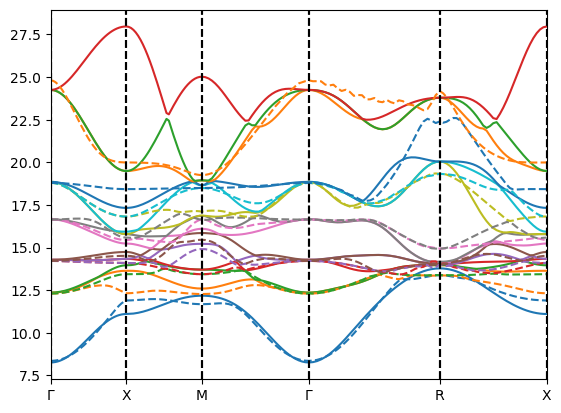

In [2]:
# read the data from Bandx.dat from Quantum Espresso
import qespresso_interface as qe
material = qe.QECrystal("nitinol_0K", [], [], [], 0)
k_smpl, _, ref_bands, symmetries, fermi_energy = material.read_bands()
print("Symmetries:", len(symmetries))
ref_bands = ref_bands[:,8:]

hsym_nitinol = hsym.HamiltonianSymmetry(Symmetry.cubic(True))
# TODO look at wannier function to find out which energy belongs to which atom
hsym_nitinol.append_s([0, 0, 0], "Ni")
#hsym_nitinol.append_s([0.5, 0.5, 0.5], "Ti")
hsym_nitinol.append_d2([0, 0, 0], "Ni")
hsym_nitinol.append_d3([0.5, 0.5, 0.5], "Ti")
hsym_nitinol.append_d2([0.5, 0.5, 0.5], "Ti")
hsym_nitinol.append_d3([0, 0, 0], "Ni")
#hsym_nitinol.append_p([0, 0, 0], "Ni")
hsym_nitinol.append_p([0.5, 0.5, 0.5], "Ti")

# now start my algorithm to find good matrices
additional_bands = 2
band_offset = 0 # = additional bands below reference

weights = np.ones(len(ref_bands[0]))
weights[0] = 0.5
weights[-1] = 1.0

neighbors = ((0, 0, 0), (1, 0, 0), (1, 1, 0), (1, 1, 1)) # works well
neighbors = Symmetry.cubic(True).complete_neighbors(neighbors)

tb_nitinol = BandStructureModel.init_tight_binding_from_ref(Symmetry.none(), neighbors, k_smpl, ref_bands, band_offset, additional_bands, cos_reduced=False, exp=True)
tb_nitinol.symmetrizer = hsym_nitinol.symmetrizer(neighbors) # for this: cos_reduced=False, exp=True
tb_nitinol.optimize(k_smpl, 1, ref_bands, weights, band_offset, 1000, 4, train_k0=True, regularization=0.99)
#tb_nitinol.optimize(k_smpl, 1, ref_bands, weights, band_offset, 2000, 4, train_k0=True, regularization=0.999)

k_smpl, ref_bands = Symmetry(symmetries).realize_symmetric_data(k_smpl, ref_bands)
path = kpaths.KPath('G').to('X').to('M').to('G').to('R').to('X')
interpolator = kpaths.interpolate(k_smpl, ref_bands, Symmetry.none(), method='cubic')
path.plot(tb_nitinol, '-')
path.plot(interpolator, '--')
#plt.ylim(8, 24)
plt.show()

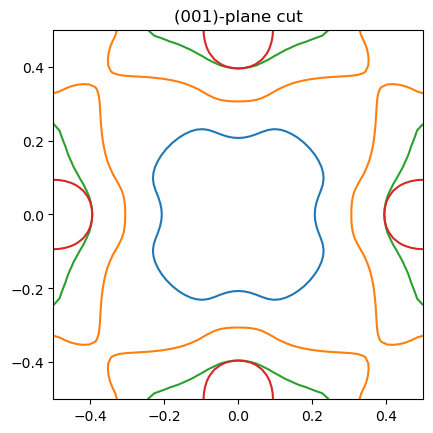

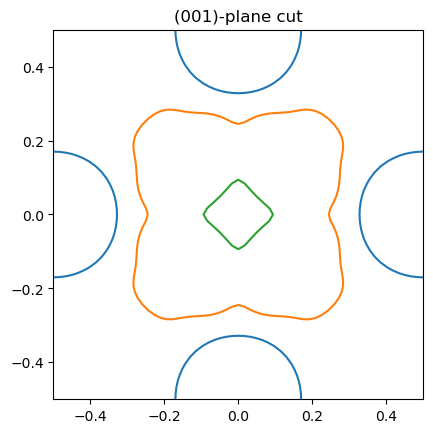

In [3]:
fs.plot_2D_fermi_surface(tb_nitinol, fermi_energy, N=63)